In [1]:
# MASH Risk Prediction with NHANES Data (2011-2018) - Consolidated Script
# This script builds and enhances a machine learning model to predict the risk of MASH
# using a reduced set of widely available clinical variables.

# --- Import Libraries ---
# Consolidating all necessary libraries from both scripts for data manipulation,
# visualization, modeling, hyperparameter tuning, and interpretation.
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import xgboost as xgb
import shap

# --- Configuration ---
# Suppress warnings for cleaner output and set display options for pandas and seaborn.
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [3]:
# --- Step 1: Load and Merge Data ---
# To accelerate future runs, the script first checks if a merged CSV file already exists.
# If it does, it loads the data directly from the CSV.
# If not, it would proceed with the commented-out merging logic (requires raw .xpt files).
merged_data_filename = 'nhanes_merged_2011_2018.csv'

if os.path.exists(merged_data_filename):
    print(f"--- Loading pre-merged data from {merged_data_filename} ---")
    raw_df = pd.read_csv(merged_data_filename, low_memory=False)
else:
    # To run this, place the .xpt files in a 'nhanes_data/' subdirectory.
    data_path = 'nhanes_data/'
    cycles = {'G': '2011-2012', 'H': '2013-2014', 'I': '2015-2016', 'J': '2017-2018'}
    file_prefixes = ['DEMO', 'BMX', 'BPX', 'TCHOL', 'TRIGLY', 'BIOPRO', 'HDL', 'GLU', 'GHB', 'CBC', 'DIQ', 'SMQ', 'ALQ', 'PAQ']
    all_cycle_dfs = []
    for letter, year in cycles.items():
        merged_df = None
        for prefix in file_prefixes:
            file_path = f"{data_path}{prefix}_{letter}.xpt"
            if os.path.exists(file_path):
                df_to_merge = pd.read_sas(file_path, format='xport')
                if merged_df is None:
                    merged_df = df_to_merge
                else:
                    merged_df = pd.merge(merged_df, df_to_merge, on='SEQN', how='left')
        if merged_df is not None:
            all_cycle_dfs.append(merged_df)
    raw_df = pd.concat(all_cycle_dfs, ignore_index=True)
    raw_df.to_csv(merged_data_filename, index=False)
    exit()

print(f"\nFinal merged shape from all cycles: {raw_df.shape}")

--- Loading pre-merged data from nhanes_merged_2011_2018.csv ---

Final merged shape from all cycles: (39156, 400)


In [10]:
# --- Step 2: Create Target Variable and Define Feature Sets ---
print("\n--- Step 2: Creating Target Variable and Defining Feature Sets ---")
# The target variable (MASH_RISK) is derived from the Fatty Liver Index (FLI).
# FLI is calculated using Triglycerides, BMI, GGT, and Waist Circumference.
# Using np.log1p for a more stable calculation if values are close to 0.
raw_df['log_TRIG'] = np.log1p(raw_df['LBXTR'])
raw_df['log_GGT'] = np.log1p(raw_df['LBXSGTSI'])
fli_numerator = np.exp(
    0.953 * raw_df['log_TRIG'] +
    0.139 * raw_df['BMXBMI'] +
    0.718 * raw_df['log_GGT'] +
    0.053 * raw_df['BMXWAIST'] - 15.745
)
raw_df['FLI'] = (fli_numerator / (1 + fli_numerator)) * 100

# Create a binary target variable 'MASH_RISK'.
# FLI >= 60 is considered high risk (1), and FLI < 30 is low risk (0).
# The "gray area" between 30 and 60 is excluded to create a clearer classification problem.
df_filtered = raw_df[(raw_df['FLI'] < 30) | (raw_df['FLI'] >= 60)].copy()
df_filtered['MASH_RISK'] = np.where(df_filtered['FLI'] >= 60, 1, 0)
print("\nTarget variable distribution:")
print(df_filtered['MASH_RISK'].value_counts(normalize=True))

# Define both the full and parsimonious feature sets for model comparison.
full_feature_columns = [
    'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'INDFMPIR',
    'LBXGLU', 'LBXGH', 'LBDHDD', 'LBDLDL', 'LBXSAL', 'LBXPLTSI',
    'LBXSATSI', 'LBXSASSI', # AST and ALT
    'BPXSY1', 'BPXDI1',
    'DIQ010', 'SMQ020', 'ALQ130', 'PAQ650'
]

parsimonious_features = [
    'RIDAGEYR',   # Age
    'RIAGENDR',   # Gender
    'BPXSY1',     # Systolic Blood Pressure
    'LBXGLU',     # Glucose
    'LBXGH',      # HbA1c
    'LBXSASSI',   # ALT
    'LBXSATSI',   # AST
    'LBXPLTSI',   # Platelet Count
    'LBDHDD',     # HDL Cholesterol
]


--- Step 2: Creating Target Variable and Defining Feature Sets ---

Target variable distribution:
MASH_RISK
0    0.514986
1    0.485014
Name: proportion, dtype: float64


In [11]:
# --- Full Model Analysis ---
print("\n--- Starting Full Model Analysis ---")

# --- Step 3a: Prepare Data for Full Model ---
model_df_full = df_filtered[['MASH_RISK'] + full_feature_columns]
print(f"\nShape of full feature dataframe before imputation: {model_df_full.shape}")
print(f"Missing values before imputation:\n{model_df_full.isnull().sum()}")

X_full = model_df_full.drop('MASH_RISK', axis=1)
y_full = model_df_full['MASH_RISK']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)


--- Starting Full Model Analysis ---

Shape of full feature dataframe before imputation: (8808, 19)
Missing values before imputation:
MASH_RISK       0
RIDAGEYR        0
RIAGENDR        0
RIDRETH1        0
INDFMPIR      806
LBXGLU          9
LBXGH          10
LBDHDD          0
LBDLDL        131
LBXSAL          0
LBXPLTSI       12
LBXSATSI        1
LBXSASSI        8
BPXSY1        668
BPXDI1        668
DIQ010          0
SMQ020       1461
ALQ130       4083
PAQ650        325
dtype: int64


In [12]:
# --- Step 4a: Build Preprocessing Pipeline for Full Model ---
categorical_features_full = ['RIAGENDR', 'RIDRETH1', 'DIQ010', 'SMQ020']
numerical_features_full = [col for col in X_full.columns if col not in categorical_features_full]

numerical_transformer_full = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),
    ('scaler', StandardScaler())])

categorical_transformer_full = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_full = ColumnTransformer(transformers=[
    ('num', numerical_transformer_full, numerical_features_full),
    ('cat', categorical_transformer_full, categorical_features_full)])

In [13]:
# --- Step 5a: Train, Tune, and Evaluate Full Models ---
print("\n--- Training, Tuning, and Evaluating Full Models ---")
lr_full = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
rf_full = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_clf_full = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Logistic Regression
lr_pipeline_full = Pipeline(steps=[('preprocessor', preprocessor_full), ('classifier', lr_full)])
lr_pipeline_full.fit(X_train_full, y_train_full)
y_prob_lr_full = lr_pipeline_full.predict_proba(X_test_full)[:, 1]

# RandomForest
rf_pipeline_full = Pipeline(steps=[('preprocessor', preprocessor_full), ('classifier', rf_full)])
param_dist_rf_full = { 'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [10, 20, 30, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4] }
random_search_rf_full = RandomizedSearchCV(rf_pipeline_full, param_distributions=param_dist_rf_full, n_iter=10, cv=5, random_state=42, n_jobs=-1, scoring='roc_auc')
random_search_rf_full.fit(X_train_full, y_train_full)
best_rf_full = random_search_rf_full.best_estimator_
y_prob_rf_full = best_rf_full.predict_proba(X_test_full)[:, 1]

# XGBoost
xgb_pipeline_full = Pipeline(steps=[('preprocessor', preprocessor_full), ('classifier', xgb_clf_full)])
param_dist_xgb_full = { 'classifier__n_estimators': [100, 200, 300], 'classifier__learning_rate': [0.01, 0.1, 0.2], 'classifier__max_depth': [3, 5, 7], 'classifier__subsample': [0.7, 0.8, 0.9], 'classifier__colsample_bytree': [0.7, 0.8, 0.9] }
random_search_xgb_full = RandomizedSearchCV(xgb_pipeline_full, param_distributions=param_dist_xgb_full, n_iter=10, cv=5, random_state=42, n_jobs=-1, scoring='roc_auc')
random_search_xgb_full.fit(X_train_full, y_train_full)
best_xgb_full = random_search_xgb_full.best_estimator_
y_prob_xgb_full = best_xgb_full.predict_proba(X_test_full)[:, 1]

# Voting Classifier
voting_clf_full = VotingClassifier(estimators=[('lr', lr_pipeline_full), ('rf', best_rf_full), ('xgb', best_xgb_full)], voting='soft')
voting_clf_full.fit(X_train_full, y_train_full)
y_prob_vote_full = voting_clf_full.predict_proba(X_test_full)[:, 1]


--- Training, Tuning, and Evaluating Full Models ---


In [14]:
# --- Parsimonious Model Analysis ---
print("\n\n--- Starting Parsimonious Model Analysis ---")

# --- Step 3b: Prepare Data for Parsimonious Model ---
model_df_p = df_filtered[['MASH_RISK'] + parsimonious_features]
print(f"\nShape of parsimonious dataframe before imputation: {model_df_p.shape}")
print(f"Missing values before imputation:\n{model_df_p.isnull().sum()}")

X_p = model_df_p.drop('MASH_RISK', axis=1)
y_p = model_df_p['MASH_RISK']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42, stratify=y_p)



--- Starting Parsimonious Model Analysis ---

Shape of parsimonious dataframe before imputation: (8808, 10)
Missing values before imputation:
MASH_RISK      0
RIDAGEYR       0
RIAGENDR       0
BPXSY1       668
LBXGLU         9
LBXGH         10
LBXSASSI       8
LBXSATSI       1
LBXPLTSI      12
LBDHDD         0
dtype: int64


In [15]:
# --- Step 4b: Build Preprocessing Pipeline for Parsimonious Model ---
categorical_features_p = ['RIAGENDR']
numerical_features_p = [col for col in X_p.columns if col not in categorical_features_p]

numerical_transformer_p = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),
    ('scaler', StandardScaler())])

categorical_transformer_p = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor_p = ColumnTransformer(transformers=[
    ('num', numerical_transformer_p, numerical_features_p),
    ('cat', categorical_transformer_p, categorical_features_p)])

In [16]:
# --- Step 5b: Train, Tune, and Evaluate Parsimonious Models ---
print("\n--- Training, Tuning, and Evaluating Parsimonious Models ---")
lr_p = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
rf_p = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_clf_p = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Logistic Regression
lr_pipeline_p = Pipeline(steps=[('preprocessor', preprocessor_p), ('classifier', lr_p)])
lr_pipeline_p.fit(X_train_p, y_train_p)
y_prob_lr_p = lr_pipeline_p.predict_proba(X_test_p)[:, 1]

# RandomForest
rf_pipeline_p = Pipeline(steps=[('preprocessor', preprocessor_p), ('classifier', rf_p)])
param_dist_rf_p = { 'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [10, 20, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4] }
random_search_rf_p = RandomizedSearchCV(rf_pipeline_p, param_distributions=param_dist_rf_p, n_iter=10, cv=5, random_state=42, n_jobs=-1, scoring='roc_auc')
random_search_rf_p.fit(X_train_p, y_train_p)
best_rf_p = random_search_rf_p.best_estimator_
y_prob_rf_p = best_rf_p.predict_proba(X_test_p)[:, 1]

# XGBoost
xgb_pipeline_p = Pipeline(steps=[('preprocessor', preprocessor_p), ('classifier', xgb_clf_p)])
param_dist_xgb_p = { 'classifier__n_estimators': [100, 200, 300], 'classifier__learning_rate': [0.01, 0.1, 0.2], 'classifier__max_depth': [3, 5, 7], 'classifier__subsample': [0.7, 0.8, 0.9], 'classifier__colsample_bytree': [0.7, 0.8, 0.9] }
random_search_xgb_p = RandomizedSearchCV(xgb_pipeline_p, param_distributions=param_dist_xgb_p, n_iter=10, cv=5, random_state=42, n_jobs=-1, scoring='roc_auc')
random_search_xgb_p.fit(X_train_p, y_train_p)
best_xgb_p = random_search_xgb_p.best_estimator_
y_prob_xgb_p = best_xgb_p.predict_proba(X_test_p)[:, 1]

# Voting Classifier
voting_clf_p = VotingClassifier(estimators=[('lr', lr_pipeline_p), ('rf', best_rf_p), ('xgb', best_xgb_p)], voting='soft')
voting_clf_p.fit(X_train_p, y_train_p)
y_prob_vote_p = voting_clf_p.predict_proba(X_test_p)[:, 1]


--- Training, Tuning, and Evaluating Parsimonious Models ---



--- Generating ROC Curve Comparison Plots ---


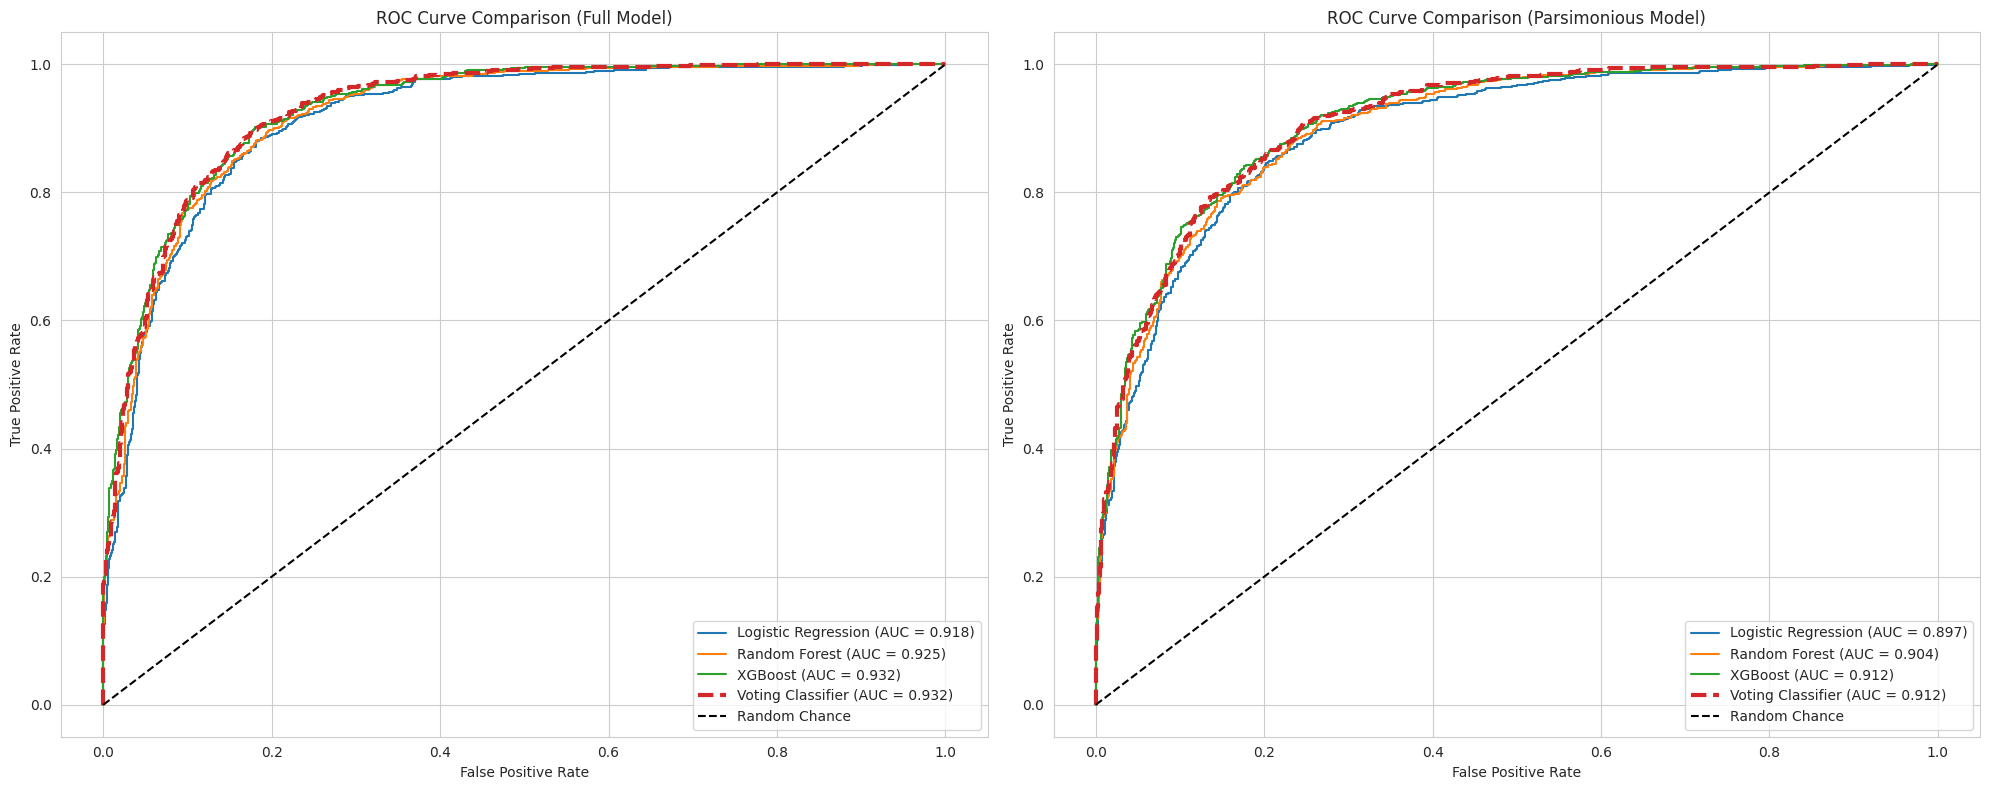

In [17]:
# --- Step 6: Plot ROC Curve Comparison for Both Models ---
print("\n--- Generating ROC Curve Comparison Plots ---")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Full Model Plot
axes[0].plot(*roc_curve(y_test_full, y_prob_lr_full)[:2], label=f'Logistic Regression (AUC = {roc_auc_score(y_test_full, y_prob_lr_full):.3f})')
axes[0].plot(*roc_curve(y_test_full, y_prob_rf_full)[:2], label=f'Random Forest (AUC = {roc_auc_score(y_test_full, y_prob_rf_full):.3f})')
axes[0].plot(*roc_curve(y_test_full, y_prob_xgb_full)[:2], label=f'XGBoost (AUC = {roc_auc_score(y_test_full, y_prob_xgb_full):.3f})')
axes[0].plot(*roc_curve(y_test_full, y_prob_vote_full)[:2], label=f'Voting Classifier (AUC = {roc_auc_score(y_test_full, y_prob_vote_full):.3f})', linewidth=3, linestyle='--')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Chance')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve Comparison (Full Model)')
axes[0].legend()

# Parsimonious Model Plot
axes[1].plot(*roc_curve(y_test_p, y_prob_lr_p)[:2], label=f'Logistic Regression (AUC = {roc_auc_score(y_test_p, y_prob_lr_p):.3f})')
axes[1].plot(*roc_curve(y_test_p, y_prob_rf_p)[:2], label=f'Random Forest (AUC = {roc_auc_score(y_test_p, y_prob_rf_p):.3f})')
axes[1].plot(*roc_curve(y_test_p, y_prob_xgb_p)[:2], label=f'XGBoost (AUC = {roc_auc_score(y_test_p, y_prob_xgb_p):.3f})')
axes[1].plot(*roc_curve(y_test_p, y_prob_vote_p)[:2], label=f'Voting Classifier (AUC = {roc_auc_score(y_test_p, y_prob_vote_p):.3f})', linewidth=3, linestyle='--')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Chance')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison (Parsimonious Model)')
axes[1].legend()

plt.tight_layout()
plt.show()


--- Interpreting Best Models with SHAP ---
Generating SHAP summary plots for the tuned Full XGBoost model...


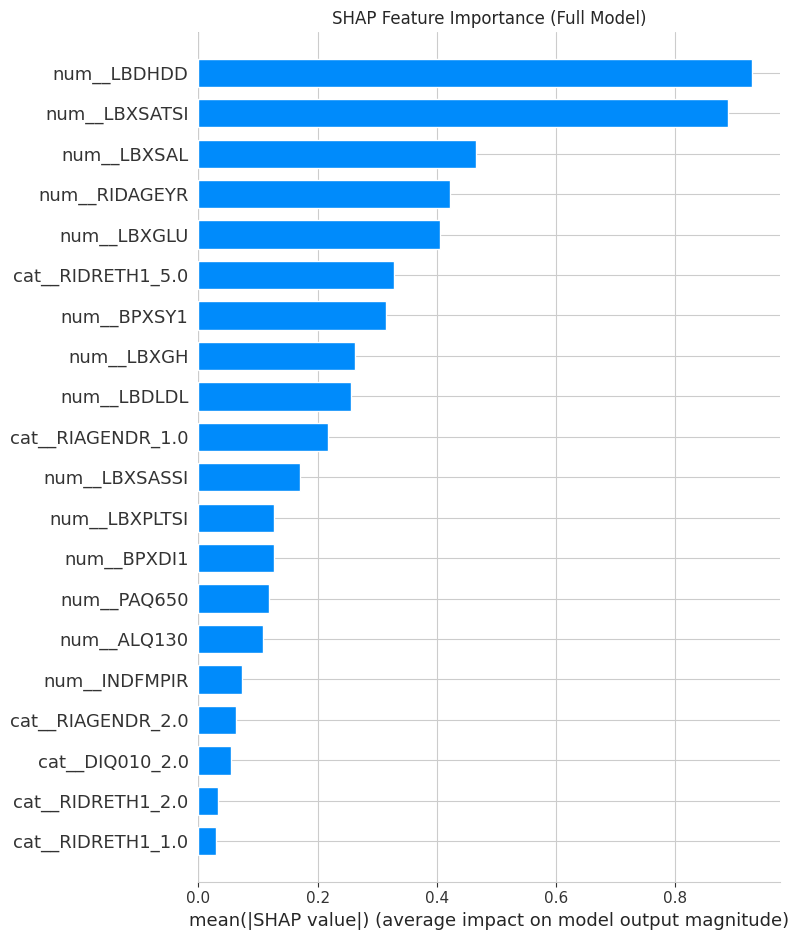


Generating SHAP summary plots for the tuned Parsimonious XGBoost model...


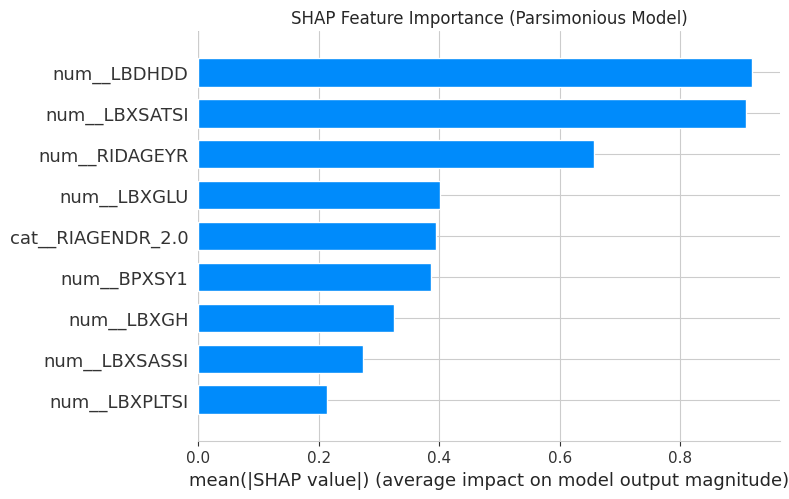


--- Script Execution Complete ---


In [18]:
# --- Step 7: Interpret the Best Model (Tuned XGBoost) with SHAP for Both Models ---
print("\n--- Interpreting Best Models with SHAP ---")

# --- SHAP for Full Model ---
preprocessor_shap_full = best_xgb_full.named_steps['preprocessor']
model_shap_full = best_xgb_full.named_steps['classifier']
X_train_transformed_full = preprocessor_shap_full.transform(X_train_full)
try:
    feature_names_full = preprocessor_shap_full.get_feature_names_out()
except AttributeError:
    ohe_features_full = preprocessor_shap_full.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features_full)
    feature_names_full = np.concatenate([numerical_features_full, ohe_features_full])
X_train_transformed_df_full = pd.DataFrame(X_train_transformed_full, columns=feature_names_full)
explainer_full = shap.TreeExplainer(model_shap_full)
shap_values_full = explainer_full.shap_values(X_train_transformed_df_full)

print("Generating SHAP summary plots for the tuned Full XGBoost model...")
plt.title("SHAP Feature Importance (Full Model)")
shap.summary_plot(shap_values_full, X_train_transformed_df_full, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# --- SHAP for Parsimonious Model ---
preprocessor_shap_p = best_xgb_p.named_steps['preprocessor']
model_shap_p = best_xgb_p.named_steps['classifier']
X_train_transformed_p = preprocessor_shap_p.transform(X_train_p)
try:
    feature_names_p = preprocessor_shap_p.get_feature_names_out()
except AttributeError:
    ohe_features_p = preprocessor_shap_p.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features_p)
    feature_names_p = np.concatenate([numerical_features_p, ohe_features_p])
X_train_transformed_df_p = pd.DataFrame(X_train_transformed_p, columns=feature_names_p)
explainer_p = shap.TreeExplainer(model_shap_p)
shap_values_p = explainer_p.shap_values(X_train_transformed_df_p)

print("\nGenerating SHAP summary plots for the tuned Parsimonious XGBoost model...")
plt.title("SHAP Feature Importance (Parsimonious Model)")
shap.summary_plot(shap_values_p, X_train_transformed_df_p, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

print("\n--- Script Execution Complete ---")
